# LeNet-5-Quantized

In this notebook, i want to demonstrate how i built LeNet-5 in PyTorch and Quantize it for visualization.


> Network details in this [Blog post ](https://engmrk.com/lenet-5-a-classic-cnn-architecture/) and architecture view can be found below.


![alt text](https://miro.medium.com/max/2625/1*1TI1aGBZ4dybR6__DI9dzA.png)


# Requirments


*   PyTorch (torch)
*   torchvision
*   numpy
*   pillow (PIL)



In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from PIL import Image

# Added by Eddie
import sys
np.set_printoptions(threshold=sys.maxsize)
import torch.quantization
import os

# MNIST Dataset

We will download the dataset with `torchvision` and add to it some transforms like padding so the size of the input images become 32x32.

We then split the data to `train_data` and `test_data` randomly.

We make another split in the training data for validation purposes using `SubsetRandomSampler`.



In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
#  validation sample
valid_sample = 0.2

transform = [transforms.Pad(2), transforms.ToTensor()]

# choose the training and test datasets
train_data = datasets.MNIST(root='data',
                            train=True,
                            download=True,
                            transform=transforms.Compose(transform))
test_data = datasets.MNIST(root='data',
                           train=False,
                           download=True,
                           transform=transforms.Compose(transform))

# Creating validation sampler
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_sample * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

# define sampler for batches
trainSampler = SubsetRandomSampler(train_idx)
validationSampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=trainSampler,
                          num_workers=num_workers)
validation_loader = DataLoader(train_data,
                               batch_size=batch_size,
                               sampler=validationSampler,
                               num_workers=num_workers)
test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         num_workers=num_workers)


# LeNet-5 Network

We inherited form `nn.Module` to construct the LeNet-5 architecture in two steps


1.   initialization of layers in `__init__`
2.   connecting layers to build the pipeline of the network in `forward`



In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.quant = torch.quantization.QuantStub('')
        # 32 x 32 x 1
        self.conv1 = nn.Conv2d(1, 6, (5, 5), padding=0, stride=1, bias= False)
        # 28 x 28 x 6
        self.pool1 = nn.MaxPool2d((2, 2), stride=2)
        # 14 x 14 x 6
        self.conv2 = nn.Conv2d(6, 16, (5, 5), padding=0, stride=1, bias= False)
        # 10 x 10 x 16
        self.pool2 = nn.MaxPool2d((2, 2), stride=2)
        # 5 x 5 x 16
        self.conv3 = nn.Conv2d(16, 120, (5, 5), padding=0, stride=1, bias= False)
        # 1 x 1 x 120
        self.fc1 = nn.Linear(120, 84, bias= False)
        self.fc2 = nn.Linear(84, 10, bias= False)
        self.dequant = torch.quantization.DeQuantStub()
    def forward(self, x):
        x = self.quant(x)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        # Choose either view or flatten (as you like)
        x = x.view(x.size(0), -1)
        # x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        x = self.dequant(x)
        return x
      
model = LeNet()

print(model)

LeNet(
  (quant): QuantStub()
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=120, out_features=84, bias=False)
  (fc2): Linear(in_features=84, out_features=10, bias=False)
  (dequant): DeQuantStub()
)


# Configurations

Here, we configure the loss function to be `CrossEntropyLoss` and the optimizer to be Stochastic Gradient Descent (`SGD`).

In [7]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Number of epochs
n_epochs = 30

# classes of MNIST
classes = list(range(10))


# Training & Validation

We first check if a GPU is available so i can transfer the learning to it then,  we put the model in training mode and after every epoch we put the model to `eval` mode so we check the validataion loss is getting better or not to save it in `model.pt`.

In [8]:
reTrain = False

# Choosing the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training Device: {}".format(device))

model.to(device)

valid_loss_min = np.Inf

if (reTrain == True):
    for epoch in range(n_epochs):

        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()  # prep model for training
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.to(device))
            # calculate the loss
            loss = criterion(output, target.to(device))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() * data.size(0)

        model.eval()
        for data, target in validation_loader:
            output = model(data.to(device))
            loss = criterion(output, target.to(device))
            valid_loss += loss.item() * data.size(0)

        # print training statistics
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(validation_loader.sampler)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.
            format(epoch + 1, train_loss, valid_loss))
        if valid_loss <= valid_loss_min:
            print(
                'Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
else:
    print("Loaded model.pt already within the directory")


Training Device: cpu
Loaded model.pt already within the directory


# Testing

Going through the testing dataset to get the accuracy of the model.

In [9]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model = LeNet()
model.load_state_dict(torch.load("model.pt"))
model.eval()  # prep model for *evaluation*
model.qconfig = torch.quantization.get_default_qconfig()

# Choosing the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Testing Device: {}".format(device))

model.to(device)

# Disabling the gradient calculations for faster inference
with torch.no_grad():

  for data, target in test_loader:
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data.to(device))
      # calculate the loss
      loss = criterion(output, target.to(device))
      # update test loss
      test_loss += loss.item() * data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %
              (str(i), 100 * class_correct[i] / class_total[i],
               np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' %
              (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' %
      (100. * np.sum(class_correct) / np.sum(class_total),
       np.sum(class_correct), np.sum(class_total)))


Testing Device: cpu
Test Loss: 1.574462

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 98% (1014/1032)
Test Accuracy of     3: 98% (999/1010)
Test Accuracy of     4: 98% (971/982)
Test Accuracy of     5: 97% (872/892)
Test Accuracy of     6: 97% (936/958)
Test Accuracy of     7: 97% (998/1028)
Test Accuracy of     8: 98% (961/974)
Test Accuracy of     9:  0% ( 0/1009)

Test Accuracy (Overall): 88% (8848/10000)


# Quantization

We deliver a visual representation to the feature maps generated from the learnt weights.

In [10]:
model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(model, inplace=True)
torch.quantization.convert(model, inplace=True)

/home/eestevez/.local/lib/python3.8/site-packages/torch/quantization/observer.py:121: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/home/eestevez/.local/lib/python3.8/site-packages/torch/quantization/observer.py:955: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


LeNet(
  (quant): Quantize(scale=tensor([1.]), zero_point=tensor([0]), dtype=torch.quint8)
  (conv1): QuantizedConv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), scale=1.0, zero_point=0, bias=False)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): QuantizedConv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), scale=1.0, zero_point=0, bias=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): QuantizedConv2d(16, 120, kernel_size=(5, 5), stride=(1, 1), scale=1.0, zero_point=0, bias=False)
  (fc1): QuantizedLinear(in_features=120, out_features=84, scale=1.0, zero_point=0, qscheme=torch.per_channel_affine)
  (fc2): QuantizedLinear(in_features=84, out_features=10, scale=1.0, zero_point=0, qscheme=torch.per_channel_affine)
  (dequant): DeQuantize()
)

# Network Analysis
We will go through every layer and print its weights (if any) and the feature maps (outputs).

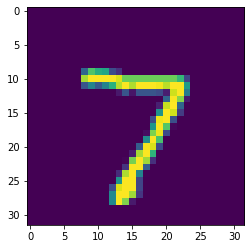

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving the model back to the CPU
model.to("cpu")

# parameters of the trained network
param = list(model.parameters())
for paramater in model.parameters():
  print(paramater.shape)
  
  
# Input image for analysis
input_img = next(iter(test_loader))[0][0].squeeze(0)
plt.imshow(input_img)

# Modifying the input image for analysis
input_img = input_img.unsqueeze(0).unsqueeze(0)

In [12]:
folderName = "weightOutputForECE554"

if not os.path.exists(folderName):
    os.makedirs(folderName)

## Conv1 Weights

In [13]:
testTensor = model.conv1.weight().int_repr()
testTensor = testTensor.type(torch.ByteTensor) # 8-bit integer (unsigned)


with open(f"{folderName}/cov1_weights.txt", "w") as f:
    f.write(str(testTensor.numpy().tolist()))

## Conv2 Weights

In [14]:
testTensor = model.conv2.weight().int_repr()
testTensor = testTensor.type(torch.ByteTensor) # 8-bit integer (unsigned)


with open(f"{folderName}/cov2_weights.txt", "w") as f:
    f.write(str(testTensor.numpy().tolist()))

## Conv3 Weights

In [15]:
testTensor = model.conv3.weight().int_repr()
testTensor = testTensor.type(torch.ByteTensor) # 8-bit integer (unsigned)

with open(f"{folderName}/cov3_weights.txt", "w") as f:
    f.write(str(testTensor.numpy().tolist()))

## FC1 Weights

In [16]:
testTensor = model.fc1.weight().int_repr()
testTensor = testTensor.type(torch.ByteTensor) # 8-bit integer (unsigned)

with open(f"{folderName}/fc1_weights.txt", "w") as f:
    f.write(str(testTensor.numpy().tolist()))

In [17]:
testTensor = model.conv3.weight().int_repr()

testTensor.size()

torch.Size([120, 16, 5, 5])

## FC2 Weights

In [18]:
testTensor = model.fc2.weight().int_repr()
testTensor = testTensor.type(torch.ByteTensor) # 8-bit integer (unsigned)

with open(f"{folderName}/fc2_weights.txt", "w") as f:
    f.write(str(testTensor.numpy().tolist()))

## Combine All Weights into one txt file

In [19]:
data0 = data1 = data2 = data3 = data4  = ""

with open(f"{folderName}/cov1_weights.txt") as fp:
    data0 = fp.read()

with open(f"{folderName}/cov2_weights.txt") as fp:
    data1 = fp.read()
    data0 += data1

with open(f"{folderName}/cov3_weights.txt") as fp:
    data2 = fp.read()
    data0 += data2

with open(f"{folderName}/fc1_weights.txt") as fp:
    data3 = fp.read()
    data0 += data3

with open(f"{folderName}/fc2_weights.txt") as fp:
    data4 = fp.read()
    data0 += data4

with open (f"{folderName}/combined_weights.txt", 'w') as fp:
    fp.write(data0)


## Strip all characters out of combined_weights.txt for an easier time parsing and loading into FPGA

In [20]:
with open(f"{folderName}/combined_weights.txt", 'r') as fp_weight:
    combinedWeightData = fp_weight.read()
fp_weight.close()

temp = combinedWeightData.replace("[","")
temp = temp.replace("]","")
temp = temp.replace(",","")
combinedWeightData = temp

with open(f"{folderName}/cleanedWeights.txt", 'w') as fp:
    fp.write(combinedWeightData)
fp.close()